<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/chexpert_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Define paths
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project/' # For local machine
# base_path = '/content/drive/MyDrive/mimic-cxr-project' # For Google Colab

In [7]:
def process_reference_files(input_files, output_prefix="", base_path=None):
    """Converts TSV files to headerless CSV files with text content only."""
    import csv, os
    from time import strftime, gmtime

    results = {}

    for input_file in input_files:
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        output_file = f"{output_prefix}{file_base}.csv"

        input_path = input_file
        output_path = output_file

        if base_path:
            if not os.path.isabs(input_file):
                input_path = os.path.join(base_path, input_file)
            output_path = os.path.join(base_path, "output", output_file)

        ref_reports = {}

        with open(input_path, 'r') as f:
            first_line = f.readline().strip()
            has_header = 'dicom_id' in first_line and '\t' in first_line

            if not has_header:
                parts = first_line.split('\t')
                if len(parts) >= 2:
                    ref_reports[parts[0]] = '\t'.join(parts[1:])

            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    ref_reports[parts[0]] = '\t'.join(parts[1:])

        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with open(output_path, 'w', newline='') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            for _, text in sorted(ref_reports.items()):
                writer.writerow([text])

        print(f"Processed {len(ref_reports)} reports from {input_file}")
        print(f"Output written to {output_path}")

        results[file_base] = ref_reports

    print(f"Completed processing {len(input_files)} files at {strftime('%Y-%m-%d %H:%M:%S', gmtime())}")

    return results

In [8]:
# List of input files
input_files = [
    "output/random.tsv",
    "output/1-gram.tsv",
    "output/2-gram.tsv",
    "output/3-gram.tsv",
    "output/reference.tsv",
    "output/1nn_reports.tsv"
]

# Process all files
results = process_reference_files(input_files, output_prefix="", base_path=base_path)


Processed 1757 reports from output/random.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random.csv
Processed 1727 reports from output/1-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1-gram.csv
Processed 1757 reports from output/2-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/2-gram.csv
Processed 1757 reports from output/3-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/3-gram.csv
Processed 1757 reports from output/reference.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/reference.csv
Processed 1757 reports from output/1nn_reports.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1nn_reports.csv
Completed processing 6 files at 2025-04-23 18:19:07


In [9]:
# docker_image_name = 'uwizeye2/chexpert-labeler:amd64'
# !docker run --platform linux/amd64 -v {base_path}output:/data {docker_image_name} python label.py --reports_path /data/reference_headerless.csv --output_path /data/labeled_reference.csv --verbose

In [10]:
import subprocess
import time

base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project/'
docker_image_name = 'uwizeye2/chexpert-labeler:amd64'
container_name = 'my_container'

files = [
    "random.csv",
    "1-gram.csv",
    "2-gram.csv",
    "3-gram.csv",
    "reference.csv",
    "1nn_reports.csv"
]

# First, ensure the container is not running
subprocess.run(f"docker ps -a --format '{{{{.Names}}}}' | grep -q '^{container_name}$' && docker rm -f {container_name}", shell=True)

# Process each file
for file in files:
    input_path = f"/data/{file}"
    output_path = f"/data/labeled_{file}"

    print(f"Processing {file}...")

    # Run the command directly with docker run each time (no container reuse due to Python version issue)
    command = f"docker run --rm --platform linux/amd64 -v {base_path}output:/data {docker_image_name} python label.py --reports_path {input_path} --output_path {output_path} --verbose"

    # Execute the command
    print(f"Executing: {command}")
    result = subprocess.run(command, shell=True)

    if result.returncode != 0:
        print(f"Error processing {file}, return code: {result.returncode}")
    else:
        print(f"Successfully processed {file}")

    print("-" * 50)

print("All files processed!")

Processing random.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/random.csv --output_path /data/labeled_random.csv --verbose


 29%|██▉       | 517/1757 [04:07<08:15,  2.50it/s]  ERROR:root:Cannot process sentence 159 in 517
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 42%|████▏     | 744/1757 [05:57<04:52,  3.46it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 54%|█████▍    | 949/1757 [07:45<06:52,  1.96it/s]ERROR:root:Cannot process sentence 371 in 949
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 62%|██████▏   | 1095/1757 [09:00<09:14,  1.19it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 63%|██████▎   | 1100/1757 [09:03<08:11,  1.34it/s]ERROR:root:No parse tree for sentence: 539
NoneType: None
 66%|██████▌   | 1154/1757 [09:30<06:29,  1.55it/s]ERROR:root:

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_random.csv.
Successfully processed random.csv
--------------------------------------------------
Processing 1-gram.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1-gram.csv --output_path /data/labeled_1-gram.csv --verbose


  6%|▌         | 103/1727 [01:55<39:55,  1.48s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 18%|█▊        | 308/1727 [05:59<40:49,  1.73s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 22%|██▏       | 387/1727 [07:23<19:26,  1.15it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 25%|██▍       | 428/1727 [08:13<28:14,  1.30s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 26%|██▌       | 445/1727 [08:32<30:40,  1.44s/it]ERROR:root:Cannot process sentence 580 in 445
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 47%|████▋     | 808/1727 [17:38<20:50,  1.36s/it]  ERROR:root:Cannot process sentence 0 in 808
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeErr

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1-gram.csv.
Successfully processed 1-gram.csv
--------------------------------------------------
Processing 2-gram.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/2-gram.csv --output_path /data/labeled_2-gram.csv --verbose


  1%|▏         | 24/1757 [00:13<18:10,  1.59it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
  2%|▏         | 43/1757 [00:22<09:07,  3.13it/s]ERROR:root:Cannot process sentence 309 in 44
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 22%|██▏       | 383/1757 [04:12<14:51,  1.54it/s]ERROR:root:Cannot process sentence 66 in 383
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 40%|███▉      | 699/1757 [08:16<18:54,  1.07s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 48%|████▊     | 844/1757 [10:25<16:42,  1.10s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 52%|█████▏    | 922/1757 [11:21<06:51,  2.03it/s]ERROR:root:Cannot proc

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_2-gram.csv.
Successfully processed 2-gram.csv
--------------------------------------------------
Processing 3-gram.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/3-gram.csv --output_path /data/labeled_3-gram.csv --verbose


  3%|▎         | 60/1757 [00:25<12:41,  2.23it/s]ERROR:root:Cannot process sentence 217 in 60
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 26%|██▌       | 455/1757 [03:17<09:12,  2.36it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 34%|███▍      | 594/1757 [04:20<15:31,  1.25it/s]ERROR:root:Cannot process sentence 0 in 594
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 71%|███████▏  | 1254/1757 [09:57<04:02,  2.07it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 73%|███████▎  | 1286/1757 [10:27<04:18,  1.82it/s]ERROR:root:Cannot process sentence 287 in 1286
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_3-gram.csv.
Successfully processed 3-gram.csv
--------------------------------------------------
Processing reference.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/reference.csv --output_path /data/labeled_reference.csv --verbose


 62%|██████▏   | 1091/1757 [08:32<05:33,  2.00it/s]ERROR:root:Cannot process sentence 114 in 1091
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 72%|███████▏  | 1267/1757 [10:05<03:54,  2.09it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 91%|█████████▏| 1606/1757 [13:22<01:52,  1.34it/s]ERROR:root:Cannot process sentence 31 in 1606
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
100%|██████████| 1757/1757 [00:00<00:00, 61215.71it/s]


Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_reference.csv.
Successfully processed reference.csv
--------------------------------------------------
Processing 1nn_reports.csv...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1nn_reports.csv --output_path /data/labeled_1nn_reports.csv --verbose


 10%|█         | 181/1757 [01:16<15:37,  1.68it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 22%|██▏       | 381/1757 [02:41<07:22,  3.11it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 23%|██▎       | 397/1757 [02:47<07:36,  2.98it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 24%|██▍       | 428/1757 [03:04<11:26,  1.94it/s]ERROR:root:Cannot process sentence 337 in 428
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 28%|██▊       | 489/1757 [03:32<08:25,  2.51it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 34%|███▍      | 595/1757 [04:16<06:00,  3.23it/s]ERROR:root:Cannot process sentence 337 in 595
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeErr

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1nn_reports.csv.
Successfully processed 1nn_reports.csv
--------------------------------------------------
All files processed!


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, accuracy_score
import os
from time import strftime, gmtime

In [12]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Define paths
# base_path = '/content/drive/MyDrive/mimic-cxr-project'
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project/' # For local machine
output_dir = os.path.join(base_path, 'output')

In [13]:
# Load labeled files
print("Loading labeled files...")
reference_df = pd.read_csv(os.path.join(output_dir, 'labeled_reference.csv'))
random_df = pd.read_csv(os.path.join(output_dir, 'labeled_random.csv'))
one_gram_df = pd.read_csv(os.path.join(output_dir, 'labeled_1-gram.csv'))
two_gram_df = pd.read_csv(os.path.join(output_dir, 'labeled_2-gram.csv'))
three_gram_df = pd.read_csv(os.path.join(output_dir, 'labeled_3-gram.csv'))
knn_df = pd.read_csv(os.path.join(output_dir, 'labeled_1nn_reports.csv'))

print(f"Reference shape: {reference_df.shape}")
print(f"Random shape: {random_df.shape}")
print(f"1-gram shape: {one_gram_df.shape}")
print(f"2-gram shape: {two_gram_df.shape}")
print(f"3-gram shape: {three_gram_df.shape}")
print(f"KNN shape: {knn_df.shape}")

Loading labeled files...
Reference shape: (1757, 15)
Random shape: (1757, 15)
1-gram shape: (1727, 15)
2-gram shape: (1757, 15)
3-gram shape: (1757, 15)
KNN shape: (1757, 15)


In [14]:
# Get all the categories (columns) except the 'Reports' column
categories = [col for col in reference_df.columns if col != 'Reports']
print(f"\nCategories: {categories}")


Categories: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [15]:
# Define evaluation function with sample matching
def calculate_metrics(true_df, pred_df):
    # Find common indices
    common_indices = true_df.index.intersection(pred_df.index)
    if len(common_indices) == 0:
        # If no common indices found by index, try matching by report text
        if 'Reports' in true_df.columns and 'Reports' in pred_df.columns:
            # Create dictionaries mapping reports to their rows
            true_reports = {report: i for i, report in enumerate(true_df['Reports'].values)}
            pred_reports = {report: i for i, report in enumerate(pred_df['Reports'].values)}
            # Find common reports
            common_reports = set(true_reports.keys()).intersection(set(pred_reports.keys()))
            if common_reports:
                print(f"Found {len(common_reports)} common reports by text matching")
                # Extract rows with common reports
                true_subset = true_df.loc[[true_reports[report] for report in common_reports]]
                pred_subset = pred_df.loc[[pred_reports[report] for report in common_reports]]
            else:
                # No matching by text either, try using the first rows
                print("No common samples found. Using first min(len1, len2) rows.")
                min_rows = min(len(true_df), len(pred_df))
                true_subset = true_df.iloc[:min_rows]
                pred_subset = pred_df.iloc[:min_rows]
        else:
            # No reports column, try matching row by row
            print("No common indices found. Using first min(len1, len2) rows.")
            min_rows = min(len(true_df), len(pred_df))
            true_subset = true_df.iloc[:min_rows]
            pred_subset = pred_df.iloc[:min_rows]
    else:
        print(f"Found {len(common_indices)} common indices")
        true_subset = true_df.loc[common_indices]
        pred_subset = pred_df.loc[common_indices]

    # Ensure all categories exist in both dataframes
    eval_categories = [col for col in categories if col in true_subset.columns and col in pred_subset.columns]

    # Fill missing values with -2 (not mentioned)
    true_subset = true_subset[eval_categories].fillna(-2)
    pred_subset = pred_subset[eval_categories].fillna(-2)

    # For accuracy: Calculate per-category accuracy
    accuracies = {}
    for category in eval_categories:
        accuracy = accuracy_score(true_subset[category], pred_subset[category])
        accuracies[category] = accuracy

    # For precision: Calculate per-category precision (for positive class only)
    true_binary = (true_subset == 1).astype(int)
    pred_binary = (pred_subset == 1).astype(int)

    precisions = {}
    for category in eval_categories:
        if sum(pred_binary[category]) > 0:  # Only if there are predicted positives
            precision = precision_score(true_binary[category], pred_binary[category], zero_division=0)
            precisions[category] = precision
        else:
            precisions[category] = 0.0

    # For F1: Calculate per-category F1
    f1_scores = {}
    for category in eval_categories:
        f1 = f1_score(true_binary[category], pred_binary[category], zero_division=0)
        f1_scores[category] = f1

    # Calculate macro averages
    macro_accuracy = np.mean(list(accuracies.values()))
    macro_precision = np.mean(list(precisions.values()))
    macro_f1 = np.mean(list(f1_scores.values()))

    # Calculate micro averages (overall)
    micro_f1 = f1_score(true_binary.values.flatten(), pred_binary.values.flatten(), zero_division=0)

    # Return all metrics
    return {
        'category_f1': f1_scores,
        'category_precision': precisions,
        'category_accuracy': accuracies,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }

In [16]:
# Evaluate models
print("\nEvaluating Random Model...")
random_metrics = calculate_metrics(reference_df, random_df)

print("\nEvaluating 1-gram Model...")
one_gram_metrics = calculate_metrics(reference_df, one_gram_df)

print("\nEvaluating 2-gram Model...")
two_gram_metrics = calculate_metrics(reference_df, two_gram_df)

print("\nEvaluating 3-gram Model...")
three_gram_metrics = calculate_metrics(reference_df, three_gram_df)

print("\nEvaluating KNN Model...")
knn_metrics = calculate_metrics(reference_df, knn_df)


Evaluating Random Model...
Found 1757 common indices

Evaluating 1-gram Model...
Found 1727 common indices

Evaluating 2-gram Model...
Found 1757 common indices

Evaluating 3-gram Model...
Found 1757 common indices

Evaluating KNN Model...
Found 1757 common indices


In [17]:
# Print summary results
print("\n===== Summary Results =====")
models = {
    'Random': random_metrics,
    '1-gram': one_gram_metrics,
    '2-gram': two_gram_metrics,
    '3-gram': three_gram_metrics,
    'KNN': knn_metrics
}

for model_name, metrics in models.items():
    print(f"\n{model_name} Model:")
    print(f"  Macro Accuracy: {metrics['macro_accuracy']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  Macro F1: {metrics['macro_f1']:.4f}")
    print(f"  Micro F1: {metrics['micro_f1']:.4f}")


===== Summary Results =====

Random Model:
  Macro Accuracy: 0.5891
  Macro Precision: 0.1658
  Macro F1: 0.1689
  Micro F1: 0.3065

1-gram Model:
  Macro Accuracy: 0.5894
  Macro Precision: 0.1698
  Macro F1: 0.1643
  Micro F1: 0.2592

2-gram Model:
  Macro Accuracy: 0.5978
  Macro Precision: 0.1843
  Macro F1: 0.1756
  Micro F1: 0.2933

3-gram Model:
  Macro Accuracy: 0.5991
  Macro Precision: 0.1769
  Macro F1: 0.1626
  Micro F1: 0.2841

KNN Model:
  Macro Accuracy: 0.6162
  Macro Precision: 0.2129
  Macro F1: 0.2086
  Micro F1: 0.3541


In [18]:
# Compare with authors' results
print("\n===== Comparison with Authors' Results =====")
authors_results = {
    'Random': {'macro_f1': 0.148},
    '1-gram': {'macro_f1': 0.185},
    '2-gram': {'macro_f1': 0.185},
    '3-gram': {'macro_f1': 0.185},
    'KNN': {'macro_f1': 0.258}
}

for model_name in models:
    our_f1 = models[model_name]['macro_f1']
    authors_f1 = authors_results[model_name]['macro_f1']
    print(f"{model_name} model macro-F1: Ours = {our_f1:.4f}, Authors = {authors_f1:.4f}")


===== Comparison with Authors' Results =====
Random model macro-F1: Ours = 0.1689, Authors = 0.1480
1-gram model macro-F1: Ours = 0.1643, Authors = 0.1850
2-gram model macro-F1: Ours = 0.1756, Authors = 0.1850
3-gram model macro-F1: Ours = 0.1626, Authors = 0.1850
KNN model macro-F1: Ours = 0.2086, Authors = 0.2580


In [19]:
# Create table of per-category F1 scores
print("\n===== Per-Category F1 Scores =====")
f1_table = pd.DataFrame({
    'Category': categories,
    'Random': [random_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '1-gram': [one_gram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '2-gram': [two_gram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    '3-gram': [three_gram_metrics['category_f1'].get(cat, np.nan) for cat in categories],
    'KNN': [knn_metrics['category_f1'].get(cat, np.nan) for cat in categories]
})

print(f1_table)


===== Per-Category F1 Scores =====
                      Category    Random    1-gram    2-gram    3-gram  \
0                   No Finding  0.158730  0.176282  0.184127  0.225131   
1   Enlarged Cardiomediastinum  0.111111  0.106618  0.152350  0.101781   
2                 Cardiomegaly  0.307430  0.195973  0.340385  0.275862   
3                  Lung Lesion  0.040816  0.022989  0.021978  0.020619   
4                 Lung Opacity  0.378979  0.340136  0.366957  0.333046   
5                        Edema  0.153257  0.168317  0.177165  0.134228   
6                Consolidation  0.069767  0.049020  0.052356  0.050955   
7                    Pneumonia  0.000000  0.044053  0.040268  0.000000   
8                  Atelectasis  0.301527  0.283262  0.262404  0.261242   
9                 Pneumothorax  0.012195  0.068783  0.063063  0.064815   
10            Pleural Effusion  0.297521  0.331361  0.272512  0.281407   
11               Pleural Other  0.000000  0.000000  0.000000  0.000000   
12

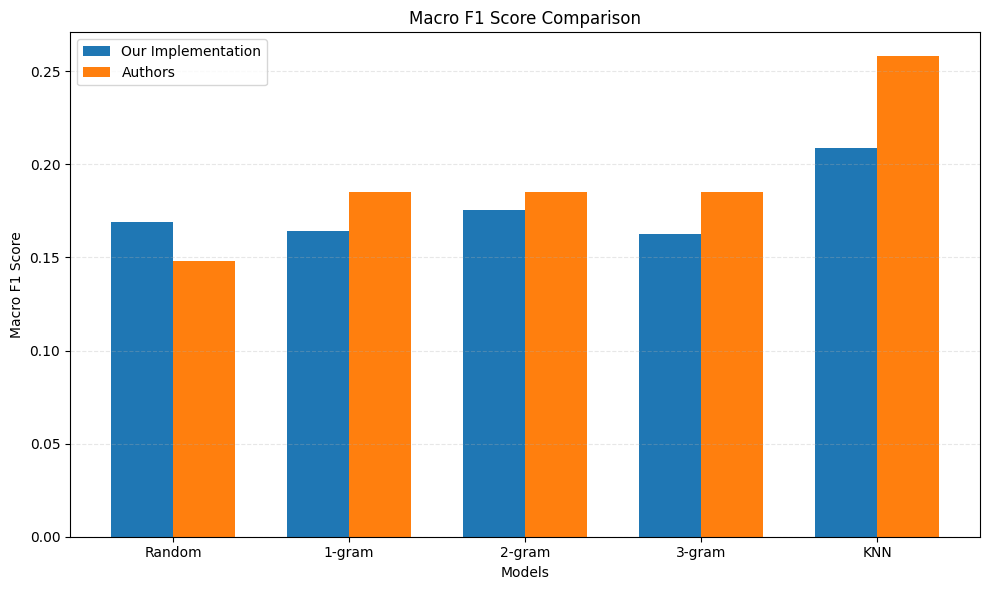

In [20]:
# Create visualization for Macro F1 Comparison
plt.figure(figsize=(10, 6))
models_list = list(models.keys())
our_f1_values = [models[model]['macro_f1'] for model in models_list]
authors_f1_values = [authors_results[model]['macro_f1'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.bar(x - width/2, our_f1_values, width, label='Our Implementation')
plt.bar(x + width/2, authors_f1_values, width, label='Authors')

plt.xlabel('Models')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score Comparison')
plt.xticks(x, models_list)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_models_f1_comparison.png'))
plt.show()